                                  MAE        MSE      RMSE        R2
Random Forest Regressor      1.004559   2.499369  1.580939  0.966669
Gradient Boosting Regressor  1.384668   3.519036  1.875909  0.953071
Decision Tree Regressor      1.342694   5.543265  2.354414  0.926077
Linear Regression            2.216339   9.741838  3.121192  0.870086
Ridge Regression             2.218260   9.751321  3.122711  0.869959
ElasticNet Regression        2.296924  10.113103  3.180111  0.865135
Lasso Regression             2.269907  10.312893  3.211369  0.862470


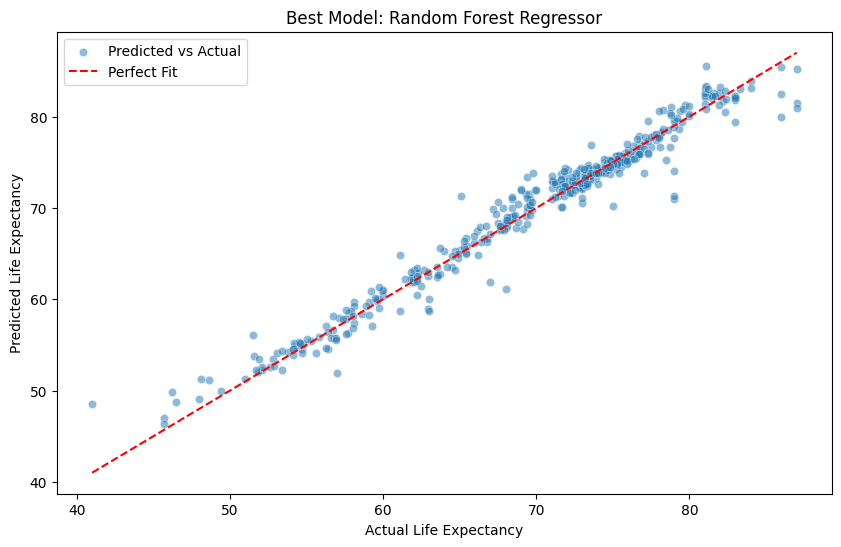

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Load the data
file_path = "Regression Data.csv"  # Change this if needed
df = pd.read_csv(file_path)

# Trim whitespace from column names
df.columns = df.columns.str.strip()

# Drop columns with excessive missing values
df_cleaned = df.drop(columns=["Population"], errors='ignore')

# Fill missing numerical values with the median
num_imputer = SimpleImputer(strategy="median")
df_cleaned.iloc[:, 3:] = num_imputer.fit_transform(df_cleaned.iloc[:, 3:])

# Encode categorical variables
label_encoder = LabelEncoder()
df_cleaned["Country"] = label_encoder.fit_transform(df_cleaned["Country"])
df_cleaned["Status"] = label_encoder.fit_transform(df_cleaned["Status"])

# Remove outliers using Z-score
df_cleaned = df_cleaned[(np.abs(stats.zscore(df_cleaned.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

# Define target variable and features
X = df_cleaned.drop(columns=["Life expectancy"], errors='ignore')
y = df_cleaned["Life expectancy"]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models and evaluate performance
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# Convert results to DataFrame and sort by best R2 score
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print(results_df)

# Plot actual vs predicted for the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Fit')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title(f"Best Model: {best_model_name}")
plt.legend()
plt.show()
